In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
all_data = pd.read_csv('../input/home-credit-default-risk/application.csv')
app_train = all_data[all_data['TARGET'].notnull()]
app_test = all_data[all_data['TARGET'].isnull()]

In [4]:
def do_model(training_data, testing_data, n_folds=5):
    y_train = training_data['TARGET']

    # Remove the feature_labels and target
    X_train = training_data.drop(columns=['SK_ID_CURR', 'TARGET'])
    test_ids = testing_data['SK_ID_CURR']
    X_test = testing_data.drop(columns=['SK_ID_CURR'])

    # One hot encode features
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # Align the dataframes by the columns
    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    print('Training Data Shape: ', X_train.shape)
    print('Testing Data Shape: ', X_test.shape)

    # Extract feature names
    feature_names = list(X_train.columns)

    # Convert to np arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # Create the kfold object
    k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(X_test.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(X_train.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Create the model
    model = lgb.LGBMClassifier(n_estimators=10000, objective='binary',
                               class_weight='balanced', learning_rate=0.05,
                               reg_alpha=0.1, reg_lambda=0.1,
                               subsample=0.8, n_jobs=-1, random_state=50)
        
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(X_train):
        # Training data for the fold
        train_features, train_labels = X_train[train_indices], y_train[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = X_train[valid_indices], y_train[valid_indices]

        # Train the model
        model.fit(train_features, train_labels, eval_metric='auc',
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], categorical_feature='auto',
                  early_stopping_rounds=100, verbose=200)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(X_test, num_iteration=best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration=best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(y_train, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics

In [5]:
submission, fi, metrics = do_model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 231)
Testing Data Shape:  (48744, 231)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.809394	train's binary_logloss: 0.536037	valid's auc: 0.763085	valid's binary_logloss: 0.554221
Early stopping, best iteration is:
[244]	train's auc: 0.817484	train's binary_logloss: 0.527581	valid's auc: 0.763329	valid's binary_logloss: 0.549149
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.808511	train's binary_logloss: 0.536921	valid's auc: 0.766144	valid's binary_logloss: 0.555131
[400]	train's auc: 0.840859	train's binary_logloss: 0.503335	valid's auc: 0.766645	valid's binary_logloss: 0.534724
Early stopping, best iteration is:
[398]	train's auc: 0.840575	train's binary_logloss: 0.503623	valid's auc: 0.766672	valid's binary_logloss: 0.534899
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.80837	train's binary_logloss: 0.537298	valid's auc: 0.77045	valid's binar

In [6]:
submission.to_csv('my_submission.csv', index=False)
print('Created submission file!')
submission

Created submission file!


,SK_ID_CURR,TARGET
307511,100001,0.264876
307512,100005,0.524253
307513,100013,0.190956
307514,100028,0.294511
307515,100038,0.706699
...,...,...
356250,456221,0.233465
356251,456222,0.556258
356252,456223,0.160070
356253,456224,0.335765


In [7]:
def plot_feature_importances(df):
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

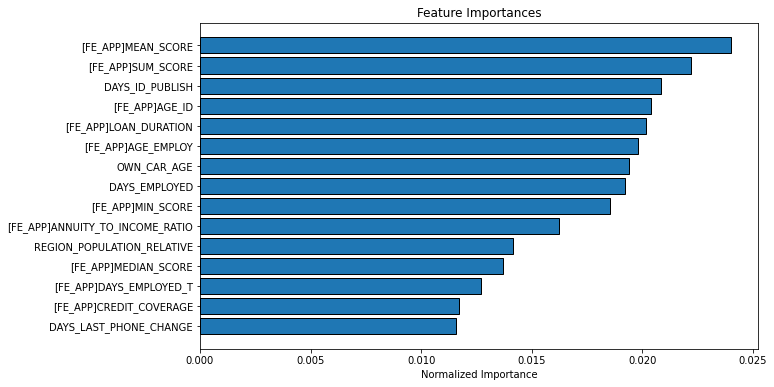

In [8]:
fi_sorted = plot_feature_importances(fi)